In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip -q install numpy
import os.path
from os import path
from pathlib import Path
import pandas as pd
import numpy as np
#Webscraping
import requests
#for stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
#Socring settings
yard_pass=0.04
td_pass=6
fd_pass=0.25
twoPC= 2.0
intcp = -4
yard_rush = 0.1
td_rush = 6
fd_rush =1
att_rush = 0.25
yard_rec = 0.1
td_rec = 6
fd_rec = 1
fmble = -2
sack = 0
rec_te = 1.5
rec = 1
Yds100Bonus = 0.5
Yds200Bonus = 1
Yds300Bonus = 2
Pass300Bonus = 1
Pass400Bonus = 2
PassCmpBonus = 1
Compl25 = 1
Carry20Bonus = 1
start_year = 2000
end_year = 2019
bonus_toggle = 1

In [3]:
#Calculate fantasy points
search_values = ['te','TE'] #filter TEs
def calcPassFP(row):
    pass_FP = yard_pass * float(row['PassYds']) + td_pass * float(row['PassTD'])+ fd_pass * float(row['Pass1D'])+ \
              intcp * float(row['Int']) + sack * float(row['Sk'])  
    #Using a CDF to calculate the likelihood of having bonuses..
    # cdf(x > val)
    #print (1 - norm.cdf(300,200, 100))
    bonus = bonus_toggle * abs(Pass300Bonus * (1-norm.cdf(300,float(row['PassY/G']),75)) * float(row['G']) + \
            Pass400Bonus * (1-norm.cdf(400,float(row['PassY/G']),75)) * float(row['G']) + \
            Compl25 * (1- norm.cdf(25,float(row['Cmp'])/float(row['G']),15) * float(row['G'])))
    #print(bonus)
    pass_FP = round(pass_FP+bonus, 2)
    return pass_FP

def calcPassFP_PG(row):
    return float(round(row['Passing FP']/(float(row['G'])),2))

#Calculate fantasy points for rushers
def calcRushFP(row):
    rush_FP = yard_rush * float(row['RushYds']) + td_rush * float(row['RushTD'])+ fd_rush * float(row['Rush1D']) + \
              fmble * float(row['RushFmb']) + att_rush * float(row['RushAtt'])
    #Using a CDF to calculate the likelihood of having bonuses..
    # cdf(x > val)
    #print (1 - norm.cdf(300,200, 100))
    #LEFT OFF HERE
    bonus = bonus_toggle *abs(Yds100Bonus * (1- norm.cdf(100,float(row['RushY/G']),20)) * float(row['G']) + \
            Yds200Bonus * (1- norm.cdf(200,float(row['RushY/G']),20)) * float(row['G']) + \
            Yds300Bonus *  (1- norm.cdf(300,float(row['RushY/G']),20)) * float(row['G']) + \
            Carry20Bonus *(1- norm.cdf(20,float(row['RushAtt']),5)) * float(row['G']))
    rush_FP = round(bonus+rush_FP,2)
    #print(rush_FP)
    #print(int(row['G']))
    return rush_FP

def calcRushFP_PG(row):
    PPG = float((float(row['Rushing FP']))/(int(row['G'])))
    PPG = round(PPG,2)
    #print(PPG)
    return PPG

#Calculate fantasy points for receivers
def calcRecFP(row):
    if ("TE" in str(row['Pos']).upper()):
        row['Pos'] = 'TE'
        rec_FP = yard_rec * float(row['RecYds']) + td_rec * float(row['RecTD'])+ fd_rec * float(row['Rec1D']) + \
                 rec_te * float(row['Rec'])
    else:
        rec_FP = yard_rec * float(row['RecYds']) + td_rec * float(row['RecTD'])+ fd_rec * float(row['Rec1D']) + \
                 rec * float(row['Rec'])
    #Using a CDF to calculate the likelihood of having bonuses..
    # cdf(x > val)
    #print (1 - norm.cdf(300,200, 100))
    #LEFT OFF HERE
    bonus = bonus_toggle *abs(Yds100Bonus * (1 - norm.cdf(100,float(row['RecY/G']),20)) * float(row['G']) + \
            Yds200Bonus * (1 - norm.cdf(200,float(row['RecY/G']),20)) * float(row['G']) + \
            Yds300Bonus *  (1 - norm.cdf(300,float(row['RecY/G']),20)) * float(row['G']))
    rec_FP = round(bonus+rec_FP,2)
    #print(rec_FP)
    #print(int(row['G']))
    return rec_FP

def calcRecFP_PG(row):
    PPG = float(row['Receiving FP'])/(float(row['G']))
    PPG = round(PPG,2)
    #print(PPG)
    return PPG
#total points
def calcTotalFP(row):
    totalFP =  round((float(row['Rushing FP']) +  float(row['Passing FP']) + float(row['Receiving FP'])),2)
    #print(totalFP)
    return totalFP

def calcTotalFP_PG(row):
    PPG = float(row['Total FP'])/(float(row['G']))
    PPG = round(PPG,2)
    #print(PPG)
    return PPG

In [4]:
#Code to download tables from pro football ref and save under the folder location with correct years
#Set save and download location
folder = "/home/bhbusch/BastianData/FantasyFootball/" #Select preferred save location e.g /home/data/UsrBot/GoLions
url = 'https://www.pro-football-reference.com/years/'
year_range= np.arange(start_year,end_year,1)
category='/passing' #change to receiving or rushing
passing_dfs = []
pd.set_option('display.max_columns', None)

for year in range(start_year,end_year+1): #loop over all years to consider, year is f.e start_year
    
    full_link = url + str(year) + str(category) + '.htm'
    #print(full_link)
    file_name = Path(folder+str(category)+str(year)+'.csv')    
    
    if not file_name.is_file():
        #Downloads all tables from the provided links as seperate .csv files.   
        html = requests.get(full_link).content
        df_list = pd.read_html(html)
        df = df_list[-1]
        print('Trying to save data from '+ full_link)
        if not (df.empty): #dataframe isn't empy, convert to csv and print
            df.to_csv(file_name)
            print('Sucessfully saved as .csv')
    else: 
        print('File:' + str(file_name)+ ' already exists.')
        
    #fill array to hold each panda dataframe 
    if (file_name.is_file()):
        passing_dfs.append(pd.read_csv(file_name,header=0)) #add dfs 
       # print("Data from "+ str(file_name) +"has been loaded into dataframe number "+ str(year-start_year))
# dfs[0] holds the start year, dfs[year-start_year] holds the last year selected => end_year

    passing_dfs[year-start_year] = passing_dfs[year-start_year].drop(passing_dfs[year-start_year].columns[0],axis=1) #remove first column
    passing_dfs[year-start_year] = passing_dfs[year-start_year].rename(columns={"Yds.1": "Yds_Sk","Yds":"PassYds","TD":"PassTD","1D":"Pass1D","Y/G":"PassY/G","Att":"PassAtt"})
    passing_dfs[year-start_year] = passing_dfs[year-start_year][passing_dfs[year-start_year].GS.apply(lambda x: x.isnumeric())] #drops all rows w/o number entries
    #Add & sort FPPG
    FP_Passing = passing_dfs[year-start_year].apply(calcPassFP,axis=1)
    passing_dfs[year-start_year]['Passing FP'] = FP_Passing
    FP_Passing_PG = passing_dfs[year-start_year].apply(calcPassFP_PG,axis=1)
    passing_dfs[year-start_year]['Passing FPPG'] = FP_Passing_PG
    #passing_dfs[year-start_year] = passing_dfs[year-start_year].drop(passing_dfs[year-start_year].columns[0],axis=1) #remove first column
    passing_dfs[year-start_year] = passing_dfs[year-start_year].sort_values(by=['Passing FP'],ascending=False) #sort by most FP
    


File:/home/bhbusch/BastianData/FantasyFootball/passing2000.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2001.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2002.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2003.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2004.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2005.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2006.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2007.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2008.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2009.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2010.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passing2011.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/passi

In [5]:
#Code to download tables from pro football ref and save under the folder location with correct years
#Set save and download location
folder = "/home/bhbusch/BastianData/FantasyFootball/"
url = 'https://www.pro-football-reference.com/years/'
year_range= np.arange(start_year,end_year,1)
category='/rushing' #change to receiving or rushing
rushing_dfs = []

for year in range(start_year,end_year+1): #loop over all years to consider
    
    full_link = url + str(year) + str(category) + '.htm'
    #print(full_link)
    file_name = Path(folder+str(category)+str(year)+'.csv')    
    
    if not file_name.is_file():
        #Downloads all tables from the provided links as seperate .csv files.   
        html = requests.get(full_link).content
        df_list = pd.read_html(html)
        df = df_list[-1]
        print('Trying to save data from '+ full_link)
        if not (df.empty): #dataframe isn't empy, convert to csv and print
            df.to_csv(file_name)
            print('Sucessfully saved as .csv')
    else: 
        print('File:' + str(file_name)+ ' already exists.')
        
    #fill array to hold each panda dataframe 
    if (file_name.is_file()):
        rushing_dfs.append(pd.read_csv(file_name,header=0)) #add dfs t
       # print("Data from "+ str(file_name) +"has been loaded into dataframe number "+ str(year-start_year))
# dfs[0] holds the start year, dfs[year-start_year] holds the last year selected => end_year

    #Code for removing double header in rushing
    new_header = rushing_dfs[year-start_year].iloc[0] #grab the first row for the header
    rushing_dfs[year-start_year] = rushing_dfs[year-start_year][1:] #take the data less the header row
    rushing_dfs[year-start_year].columns = new_header #set the header row as the df header
    rushing_dfs[year-start_year] = rushing_dfs[year-start_year][rushing_dfs[year-start_year].GS.apply(lambda x: x.isnumeric())] #drops all rows w/o number entries
    rushing_dfs[year-start_year] = rushing_dfs[year-start_year].rename(columns={"Yds":"RushYds","TD":"RushTD","1D":"Rush1D","Fmb":"RushFmb","Att":"RushAtt","Y/G":"RushY/G"})
    
    #Test rushing points
    FP_Rushing = rushing_dfs[year-start_year].apply(calcRushFP,axis=1)
    rushing_dfs[year-start_year]['Rushing FP'] = FP_Rushing
    FP_Rushing_PG = rushing_dfs[year-start_year].apply(calcRushFP_PG,axis=1)
    rushing_dfs[year-start_year]['Rushing FPPG'] = FP_Rushing_PG
    #rushing_df = rushing_df.sort_values(by=['Rushing FP PG'],ascending=False) #sort by most FP
    #rushing_df[1:25]

File:/home/bhbusch/BastianData/FantasyFootball/rushing2000.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2001.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2002.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2003.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2004.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2005.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2006.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2007.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2008.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2009.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2010.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushing2011.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/rushi

In [6]:
#Code to download tables from pro football ref and save under the folder location with correct years
#Set save and download location
folder = "/home/bhbusch/BastianData/FantasyFootball/" #Select preferred save location e.g /home/data/UsrBot/GoLions
url = 'https://www.pro-football-reference.com/years/'
year_range= np.arange(start_year,end_year,1)
category='/receiving' #change to receiving or rushing
receiving_dfs = []
pd.set_option('display.max_columns', None)

for year in range(start_year,end_year+1): #loop over all years to consider, year is f.e start_year
    
    full_link = url + str(year) + str(category) + '.htm'
    #print(full_link)
    file_name = Path(folder+str(category)+str(year)+'.csv')    
    
    if not file_name.is_file():
        #Downloads all tables from the provided links as seperate .csv files.   
        html = requests.get(full_link).content
        df_list = pd.read_html(html)
        df = df_list[-1]
        print('Trying to save data from '+ full_link)
        if not (df.empty): #dataframe isn't empy, convert to csv and print
            df.to_csv(file_name)
            print('Sucessfully saved as .csv')
    else: 
        print('File:' + str(file_name)+ ' already exists.')
        
    #fill array to hold each panda dataframe 
    if (file_name.is_file()):
        receiving_dfs.append(pd.read_csv(file_name,header=0)) #add dfs 
        # print("Data from "+ str(file_name) +"has been loaded into dataframe number "+ str(year-start_year))
        # dfs[0] holds the start year, dfs[year-start_year] holds the last year selected => end_year

    receiving_dfs[year-start_year] = receiving_dfs[year-start_year].drop(receiving_dfs[year-start_year].columns[0],axis=1) #remove first column
    receiving_dfs[year-start_year] = receiving_dfs[year-start_year].rename(columns=\
                               {"Yds": "RecYds","TD":"RecTD","1D":"Rec1D","Fmb":"RecFmb","Y/G":"RecY/G"})
    receiving_dfs[year-start_year] = receiving_dfs[year-start_year][receiving_dfs[year-start_year].GS.apply(lambda x: x.isnumeric())] #drops all rows w/o number entries
    #Add & sort FPPG
    FP_receiving = receiving_dfs[year-start_year].apply(calcRecFP,axis=1)
    receiving_dfs[year-start_year]['Receiving FP'] = FP_receiving
    FP_receiving_PG = receiving_dfs[year-start_year].apply(calcRecFP_PG,axis=1)
    receiving_dfs[year-start_year]['Receiving FPPG'] = FP_receiving_PG
    receiving_dfs[year-start_year] = receiving_dfs[year-start_year].sort_values(by=['Receiving FPPG'],ascending=False) #sort by most FP
    #receiving_dfs[year-start_year][receiving_dfs[year-start_year]['Pos'].str.contains('|'.join(search_values ),na=False)] #show only TEs
    #receiving_dfs[year-start_year][receiving_dfs[year-start_year]['Player'].str.contains("Travis",na=False)] #show only KELCE
    #receiving_dfs[year-start_year] = receiving_dfs[year-start_year].drop(['Rk'],axis=1) #remove first column
    #receiving_dfs[year-start_year].sort_values(by=['Receiving FP'],ascending=False) #sort by most FP
    #pd.set_option("display.max_rows", None, "dislay.max_columns", None)
    #receiving_dfs[year-start_year][receiving_df['Player'].str.contains("Hoop",na=False)] #show only KELCE


File:/home/bhbusch/BastianData/FantasyFootball/receiving2000.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2001.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2002.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2003.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2004.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2005.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2006.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2007.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2008.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2009.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2010.csv already exists.
File:/home/bhbusch/BastianData/FantasyFootball/receiving2011.csv already exists.
File:/home/bhbusch/BastianDa

In [41]:
merged_dfs = []
total_dfs = []
QB_dfs = []
WR_dfs = []
RB_dfs = []
TE_dfs = []
newDF = pd.DataFrame() #creates a new dataframe that's empty


for year in range(start_year,end_year+1): #loop over all years to consider, year is f.e start_year
    merged_dfs.append(pd.read_csv(file_name,header=0)) #add dfs
    merged_dfs[year-start_year] = rushing_dfs[year-start_year][['Player','G','Tm','Age','Pos','RushAtt','RushYds','RushTD','Rush1D','Rushing FP', 'Rushing FPPG']].merge( \
            receiving_dfs[year-start_year][['Player','G','Tm','Age','Pos','Rec','RecYds','RecTD','Rec1D','RecY/G','Receiving FP','Receiving FPPG']],\
            on = ['Player','G','Tm','Age','Pos'],how = 'outer')
    merged_dfs[year-start_year] = merged_dfs[year-start_year].replace(np.nan,0)
    
    total_dfs.append(pd.read_csv(file_name,header=0))
    total_dfs[year-start_year] = passing_dfs[year-start_year][['Player','G','Tm', 'Age','Pos','Cmp','PassAtt','PassYds' ,'PassTD','Int','Sk','Passing FP','Passing FPPG']].merge( \
            merged_dfs[year-start_year][['Player','G','Tm','Age','Pos','Rec','RecYds','RecTD','Rec1D','RecY/G','Receiving FP','Receiving FPPG','RushAtt',\
                      'RushYds','RushTD','Rush1D','Rushing FP', 'Rushing FPPG']],on = ['Player','Tm','Age','Pos'],how = 'outer')
    

    total_dfs[year-start_year] = total_dfs[year-start_year].replace(np.nan,0)
    #Code to recover Team, Pos and Age
    total_dfs[year-start_year]['G_x'] = np.where(total_dfs[year-start_year]['G_x'] == 0, total_dfs[year-start_year]['G_y'], total_dfs[year-start_year]['G_x'])
    total_dfs[year-start_year] = total_dfs[year-start_year].drop(['G_y'], axis=1)
    #total_dfs[year-start_year]['Tm_x'] = np.where(total_dfs[year-start_year]['Tm_x'] == 0, total_dfs[year-start_year]['Tm_y'], total_dfs[year-start_year]['Tm_x'])
    #total_dfs[year-start_year] = total_dfs[year-start_year].drop(['Tm_y'], axis=1)
    #total_dfs[year-start_year]['Age_x'] = np.where(total_dfs[year-start_year]['Age_x'] == 0, total_dfs[year-start_year]['Age_y'], total_dfs[year-start_year]['Age_x'])
    #total_dfs[year-start_year] = total_dfs[year-start_year].drop(['Age_y'], axis=1)
    #total_dfs[year-start_year]['Pos_x'] = np.where(total_dfs[year-start_year]['Pos_x'] == 0, total_dfs[year-start_year]['Pos_y'], total_dfs[year-start_year]['Pos_x'])
    #total_dfs[year-start_year] = total_dfs[year-start_year].drop(['Pos_y'], axis=1)

    total_dfs[year-start_year] = total_dfs[year-start_year].rename(columns={"G_x": "G","Tm_x":"Tm","Age_x":"Age","Pos_x":"Pos"})
    total_dfs[year-start_year]['Season'] = int(year)
    
    
    FP_Total = total_dfs[year-start_year].apply(calcTotalFP,axis=1)
    total_dfs[year-start_year]['Total FP'] = FP_Total

    total_dfs[year-start_year] = total_dfs[year-start_year][total_dfs[year-start_year].G != 0] #remove erroneous 0 Game entries
    FP_Total_PG = total_dfs[year-start_year].apply(calcTotalFP_PG,axis=1)
    total_dfs[year-start_year]['Total FPPG'] = FP_Total_PG
    total_dfs[year-start_year] = total_dfs[year-start_year].sort_values(by=['Total FP'],ascending=False) #sort by most FPPG

    #total_dfs[year-start_year] = total_dfs[year-start_year][['Player','Tm','G','Age','Pos','Passing FP','Passing FPPG','Receiving FP','Receiving FPPG','Rushing FP','Rushing FPPG','Total FP','Total FPPG']]
    #total_dfs[year-start_year].set_index('Player',inplace=True)
    #total_dfs[year-start_year] = total_dfs[year-start_year][0:275]
    total_dfs[year-start_year].index = np.arange(1, len(total_dfs[year-start_year]) + 1)

    #append each df to list
    QB_dfs.append(pd.read_csv(file_name,header=0))
    RB_dfs.append(pd.read_csv(file_name,header=0))
    WR_dfs.append(pd.read_csv(file_name,header=0))
    TE_dfs.append(pd.read_csv(file_name,header=0))
    #FIlter the copied dfs
    QB_dfs[year-start_year] = total_dfs[year-start_year].loc[total_dfs[year-start_year]['Pos'].isin(['QB','qb'])] #show QBs
    RB_dfs[year-start_year] = total_dfs[year-start_year].loc[total_dfs[year-start_year]['Pos'].isin(['RB','rb'])] #show QBs
    WR_dfs[year-start_year] = total_dfs[year-start_year].loc[total_dfs[year-start_year]['Pos'].isin(['WR','wr'])] #show QBs
    TE_dfs[year-start_year] = total_dfs[year-start_year].loc[total_dfs[year-start_year]['Pos'].isin(['TE','TE/te','te'])] #show QBs
    TE_dfs[year-start_year].index = np.arange(1, len(TE_dfs[year-start_year]) + 1)
    QB_dfs[year-start_year].index = np.arange(1, len(QB_dfs[year-start_year]) + 1)
    WR_dfs[year-start_year].index = np.arange(1, len(WR_dfs[year-start_year]) + 1)
    RB_dfs[year-start_year].index = np.arange(1, len(RB_dfs[year-start_year]) + 1)
    #Add to new DF
    newDF = newDF.append(total_dfs[year-start_year].loc[total_dfs[year-start_year]['Player'].str.contains("Le'Veon Bell",na=False)],sort=False)
newDF

,Player,G,Tm,Age,Pos,Cmp,PassAtt,PassYds,PassTD,Int,Sk,Passing FP,Passing FPPG,Rec,RecYds,RecTD,Rec1D,RecY/G,Receiving FP,Receiving FPPG,RushAtt,RushYds,RushTD,Rush1D,Rushing FP,Rushing FPPG,Season,Total FP,Total FPPG
33,Le'Veon Bell,13,PIT,21,RB,0,0,0,0,0,0,0.00,0.00,45,399,0,15,30.7,99.90,7.68,244,860,8,53,259.30,19.95,2013,359.20,27.63
1,Le'Veon Bell*+,16,PIT,22,RB,0,0,0,0,0,0,0.00,0.00,83,854,3,41,53.4,227.48,14.22,290,1361,8,75,349.43,21.84,2014,576.91,36.06
138,Le'Veon Bell,6,PIT,23,RB/rb,0,0,0,0,0,0,0.00,0.00,24,136,0,4,22.7,41.60,6.93,113,556,3,27,135.92,22.65,2015,177.52,29.59
5,Le'Veon Bell*,12,PIT,24,RB,0,1,0,0,0,0,10.43,0.87,75,616,2,32,51.3,180.64,15.05,261,1268,7,70,311.72,25.98,2016,502.79,41.90
2,Le'Veon Bell*+,15,PIT,25,RB,0,0,0,0,0,0,0.00,0.00,85,655,2,32,43.7,194.52,12.97,321,1291,9,71,345.18,23.01,2017,539.70,35.98
31,Le'Veon Bell,15,NYJ,27,RB,0,0,0,0,0,0,0.00,0.00,66,461,1,20,30.7,138.10,9.21,245,789,3,36,207.22,13.81,2019,345.32,23.02


2016 :QB Tier 0: 427.45 Next tier below: 332.16  157.72  39.43
2016 :WR Tier 0: 427.45 Next tier below: 268.88  235.26  202.36
2016 :RB Tier 0: 440.89 Next tier below: 302.4  178.43  53.63
2016 :TE Tier 0: 258.65 Next tier below: 175.3  108.23  60.42

2017 :QB Tier 0: 399.78 Next tier below: 304.1  151.77  44.17
2017 :WR Tier 0: 399.78 Next tier below: 246.6  202.68  167.89
2017 :RB Tier 0: 402.42 Next tier below: 274.96  171.6  85.12
2017 :TE Tier 0: 245.82 Next tier below: 147.09  78.56  45.01

2018 :QB Tier 0: 460.86 Next tier below: 318.42  178.96  43.53
2018 :WR Tier 0: 460.86 Next tier below: 272.66  204.24  165.24
2018 :RB Tier 0: 440.02 Next tier below: 281.22  161.71  73.86
2018 :TE Tier 0: 255.92 Next tier below: 122.49  77.56  48.05

2019 :QB Tier 0: 434.77 Next tier below: 326.37  174.16  45.27
2019 :WR Tier 0: 434.77 Next tier below: 278.92  230.2  185.91
2019 :RB Tier 0: 446.82 Next tier below: 318.12  229.16  101.75
2019 :TE Tier 0: 261.34 Next tier below: 148.94  116.01

/home/bhbusch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/bhbusch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


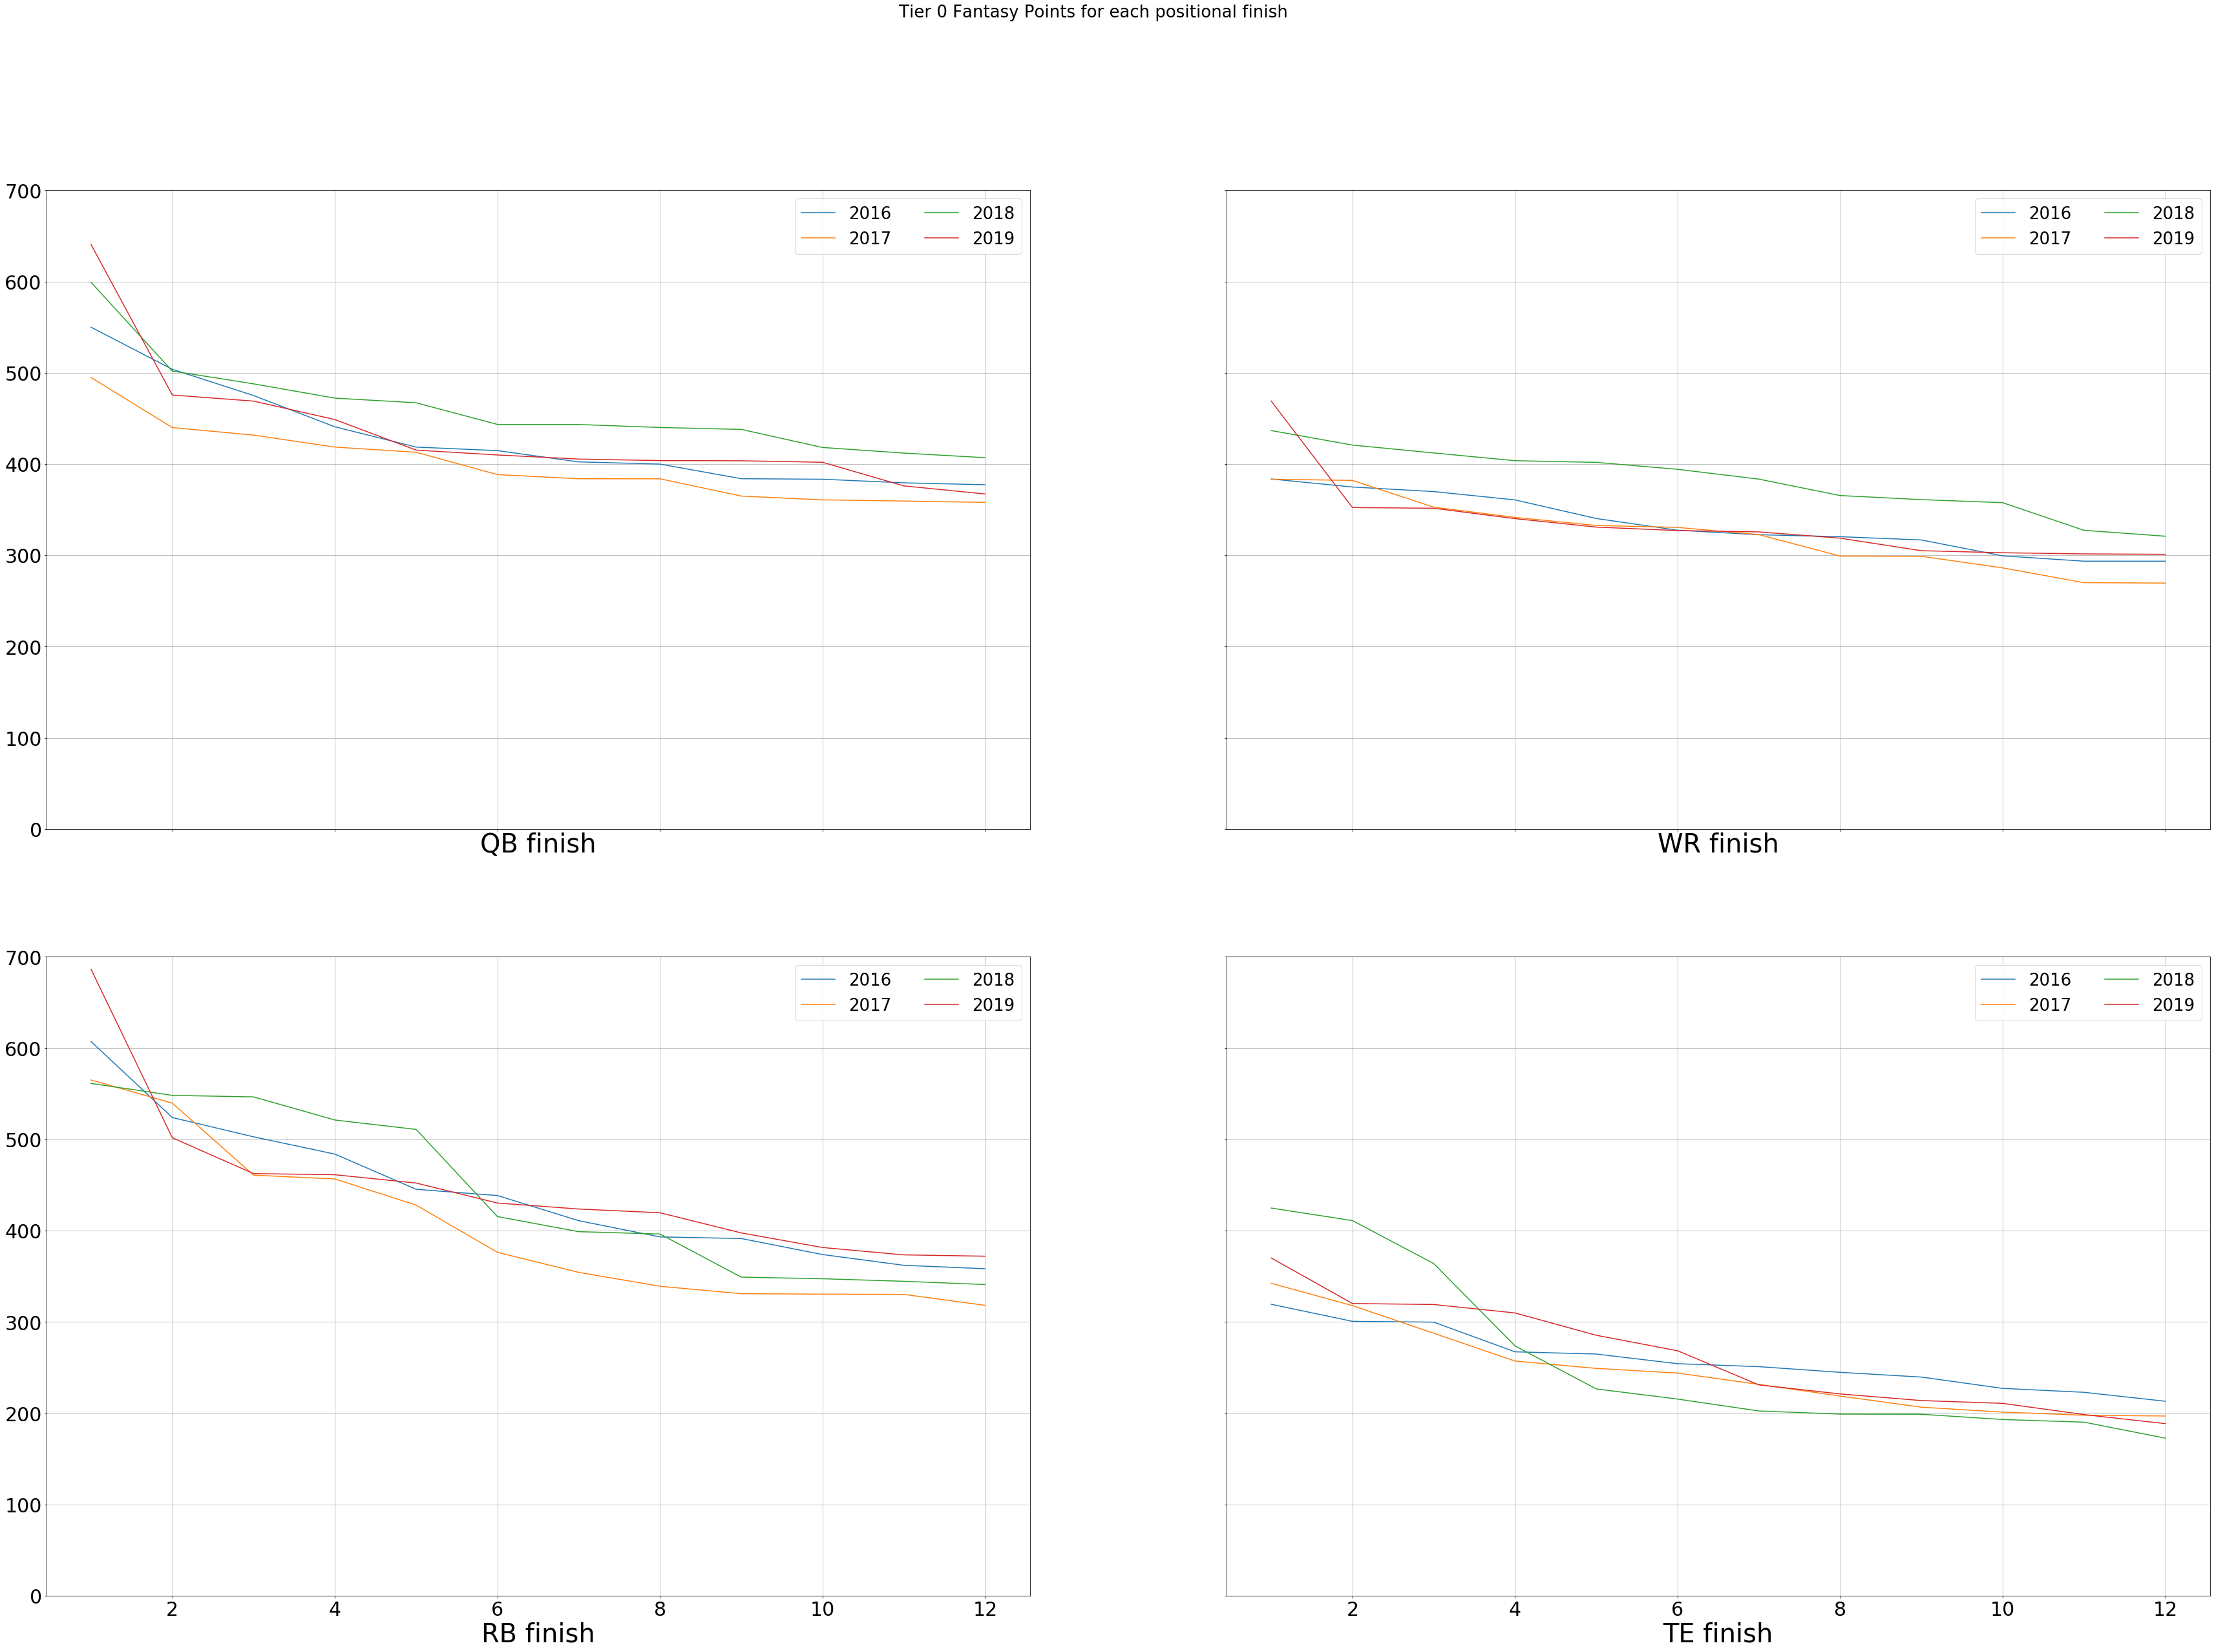

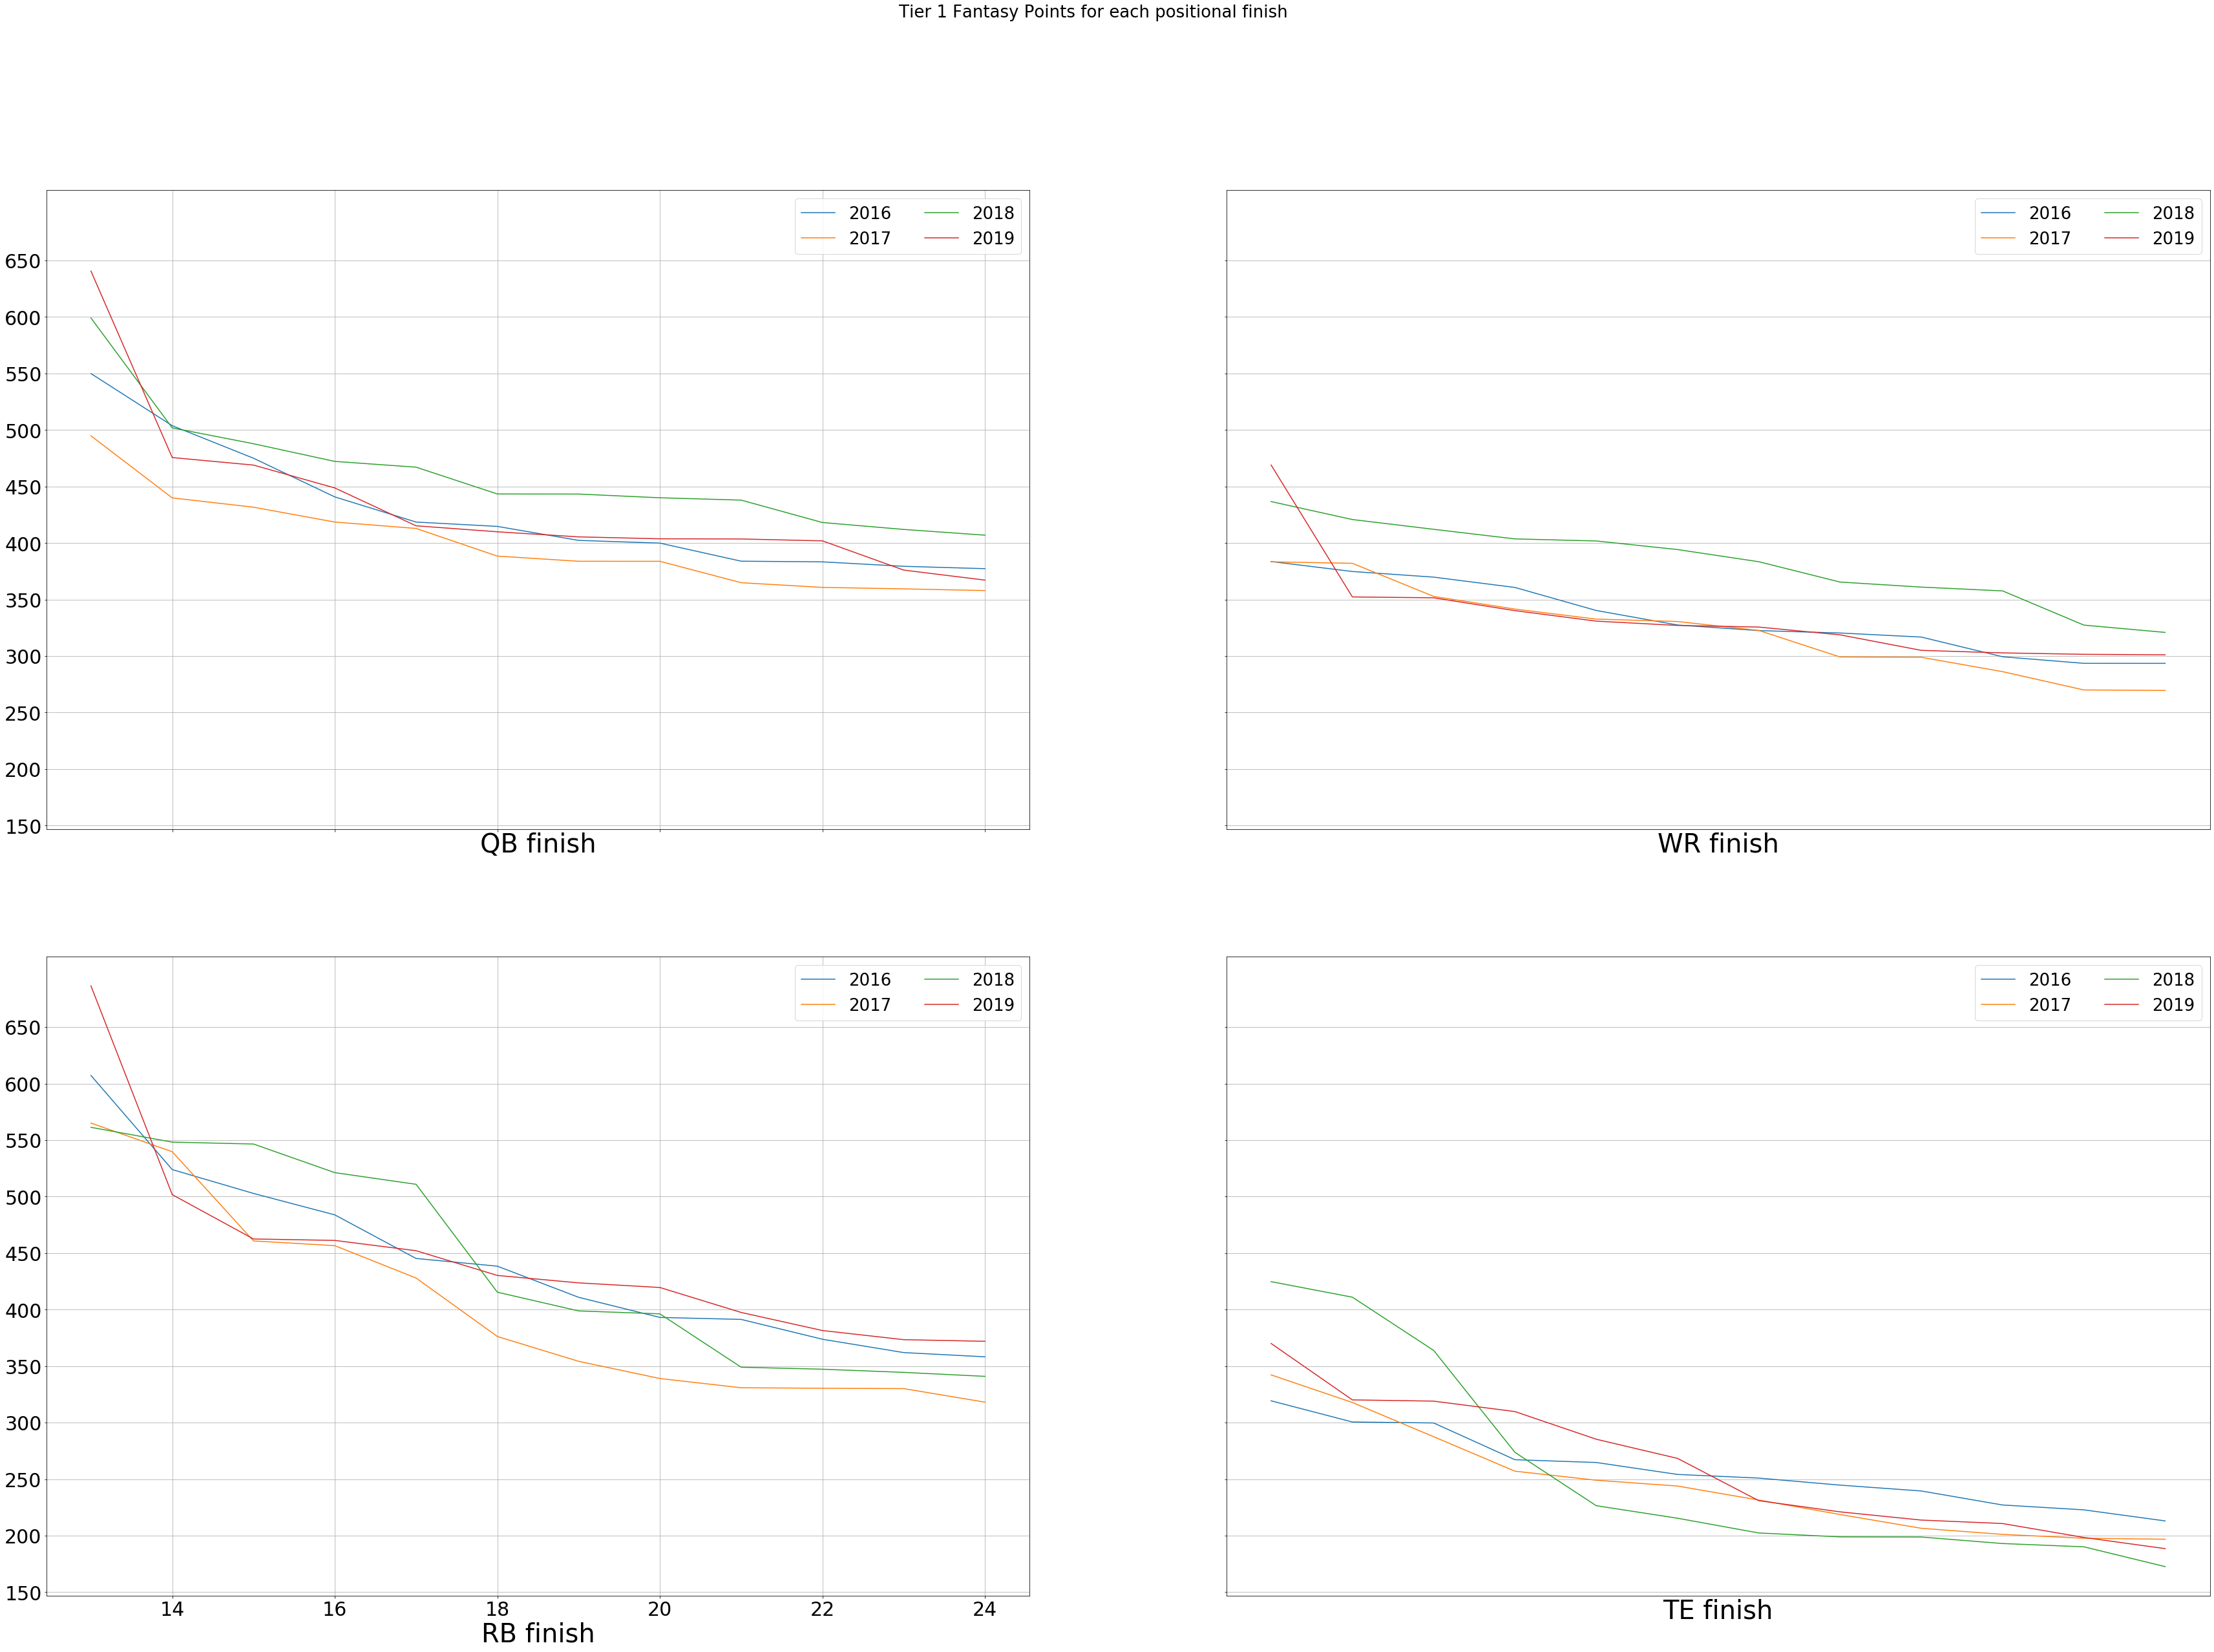

In [37]:
#What do i want to do: plots for each position  
#Fig1 contains positional plots over the years
begin_year=2016
final_year=2019
fig1, ax = plt.subplots(2, 2, sharex='col',sharey=True, figsize=(60, 40))
fig2, ax1 = plt.subplots(2, 2, sharex='col',sharey=True,figsize=(60, 40))

#fig2, ax2 = plt.subplots((end_year-start_year)+1,1,sharex='col', sharey=True, figsize=(15, 30))

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.rc('legend', fontsize=26)    # legend fontsize
plt.rcParams['axes.grid'] = True

#color = ['red','blue','green','black']
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 700)
# Setting the values for all axes.
plt.setp(ax, ylim=custom_ylim)
#plt.setp(ax2, ylim=custom_ylim)
plt.yticks(np.arange(custom_ylim[0],custom_ylim[1], 50)) 
plt.xticks(np.arange(1)) 


for year in range(begin_year,final_year+1): #loop over all years to consider, year is f.e start_year
    #Grouping into tiers
    thresh_arr = [12, 24, 36, 48]
    TE_tier0 = TE_dfs[year-start_year][0:thresh_arr[0]]
    TE_tier1 = TE_dfs[year-start_year][thresh_arr[0]:thresh_arr[1]]
    TE_tier2 = TE_dfs[year-start_year][thresh_arr[1]:thresh_arr[2]]
    TE_tier3 = TE_dfs[year-start_year][thresh_arr[2]:thresh_arr[3]]
    TE_tier4 = TE_dfs[year-start_year][thresh_arr[3]:len(TE_dfs)+1]
    #QB
    QB_tier0 = QB_dfs[year-start_year][0:thresh_arr[0]]
    QB_tier1 = QB_dfs[year-start_year][thresh_arr[0]:thresh_arr[1]]
    QB_tier2 = QB_dfs[year-start_year][thresh_arr[1]:thresh_arr[2]]
    QB_tier3 = QB_dfs[year-start_year][thresh_arr[2]:thresh_arr[3]]
    QB_tier4 = QB_dfs[year-start_year][thresh_arr[3]:len(QB_dfs)+1]
    #RB
    RB_tier0 = RB_dfs[year-start_year][0:thresh_arr[0]]
    RB_tier1 = RB_dfs[year-start_year][thresh_arr[0]:thresh_arr[1]]
    RB_tier2 = RB_dfs[year-start_year][thresh_arr[1]:thresh_arr[2]]
    RB_tier3 = RB_dfs[year-start_year][thresh_arr[2]:thresh_arr[3]]
    RB_tier4 = RB_dfs[year-start_year][thresh_arr[3]:len(RB_dfs)+1]
    #WR
    WR_tier0 = WR_dfs[year-start_year][0:thresh_arr[0]]
    WR_tier1 = WR_dfs[year-start_year][thresh_arr[0]:thresh_arr[1]]
    WR_tier2 = WR_dfs[year-start_year][thresh_arr[1]:thresh_arr[2]]
    WR_tier3 = WR_dfs[year-start_year][thresh_arr[2]:thresh_arr[3]]
    WR_tier4 = WR_dfs[year-start_year][thresh_arr[3]:len(WR_dfs)+1]
   
       #Print Tier stats
    #print("Tier 0: Top "+str(thresh_arr[0]))
    #print(str(year) + " :QB Tier 0:" + str(round(QB_tier0['Total FP'].mean(),2)))
    #print(str(year) + ": WR Tier 0: "+ str(round(WR_tier0['Total FP'].mean(),2)))
    #print(str(year) + ": RB Tier 0: "+ str(round(RB_tier0['Total FP'].mean(),2)))
    #print(str(year) + ": TE Tier 0: "+ str(round(TE_tier0['Total FP'].mean(),2))+"\n")
    #Plotting of first fig
    ax[0,0].plot(QB_tier0.index,QB_tier0['Total FP'],label=year)
    ax[0,1].plot(WR_tier0.index,WR_tier0['Total FP'],label=year)
    ax[1,0].plot(RB_tier0.index,RB_tier0['Total FP'],label=year)
    ax[1,1].plot(TE_tier0.index,TE_tier0['Total FP'],label=year)
    
    #Plotting of first fig
    ax1[0,0].plot(QB_tier1.index,QB_tier0['Total FP'],label=year)
    ax1[0,1].plot(WR_tier1.index,WR_tier0['Total FP'],label=year)
    ax1[1,0].plot(RB_tier1.index,RB_tier0['Total FP'],label=year)
    ax1[1,1].plot(TE_tier1.index,TE_tier0['Total FP'],label=year)
    
    #Print Tier1 stats
    #print("Tier 1: Top "+str(thresh_arr[0]+1) + " to " + str(thresh_arr[1]))
    print(str(year) + " :QB Tier 0: "+ str(round(QB_tier0['Total FP'].mean(),2))+ " Next tier below: " +\
             str(round(QB_tier1['Total FP'].mean(),2)) + "  " + str(round(QB_tier2['Total FP'].mean(),2)) + "  "+\
             str(round(QB_tier3['Total FP'].mean(),2)))
    print(str(year) + " :WR Tier 0: "+ str(round(QB_tier0['Total FP'].mean(),2))+ " Next tier below: " +\
             str(round(WR_tier1['Total FP'].mean(),2)) + "  " + str(round(WR_tier2['Total FP'].mean(),2)) + "  "+\
             str(round(WR_tier3['Total FP'].mean(),2)))
    print(str(year) + " :RB Tier 0: "+ str(round(RB_tier0['Total FP'].mean(),2))+ " Next tier below: " +\
             str(round(RB_tier1['Total FP'].mean(),2)) + "  " + str(round(RB_tier2['Total FP'].mean(),2)) + "  "+\
             str(round(RB_tier3['Total FP'].mean(),2)))
    print(str(year) + " :TE Tier 0: "+ str(round(TE_tier0['Total FP'].mean(),2))+ " Next tier below: " +\
             str(round(TE_tier1['Total FP'].mean(),2)) + "  " + str(round(TE_tier2['Total FP'].mean(),2)) + "  "+\
             str(round(TE_tier3['Total FP'].mean(),2))+"\n")    

    #ax2[year-start_year].scatter(total_dfs[year-start_year].index,total_dfs[year-start_year]['Total FPPG'],\
     #                   c=total_dfs[year-start_year]['Pos'],alpha = 0.4)
#Plot fig1 stuff
ax[0,0].legend(ncol=int(2),loc='upper right')
ax[0,1].legend(ncol=int(2),loc='upper right')
ax[1,0].legend(ncol=int(2),loc='upper right')
ax[1,1].legend(ncol=int(2),loc='upper right')
ax[0,0].set_xlabel('QB finish')
ax[0,1].set_xlabel('WR finish')
ax[1,0].set_xlabel('RB finish')
ax[1,1].set_xlabel('TE finish')
#Plot fig2 stuff
ax1[0,0].legend(ncol=int(2),loc='upper right')
ax1[0,1].legend(ncol=int(2),loc='upper right')
ax1[1,0].legend(ncol=int(2),loc='upper right')
ax1[1,1].legend(ncol=int(2),loc='upper right')
ax1[0,0].set_xlabel('QB finish')
ax1[0,1].set_xlabel('WR finish')
ax1[1,0].set_xlabel('RB finish')
ax1[1,1].set_xlabel('TE finish')
fig1.suptitle('Tier 0 Fantasy Points for each positional finish', fontsize=26)
fig1.show()
fig1.savefig('Tier0.png')
#Plot fig 2 stuff
fig2.suptitle('Tier 1 Fantasy Points for each positional finish', fontsize=26)
fig2.show()
fig2.savefig('Tier1.png')


In [9]:
#total_dfs[17][0:50]['Pos'].value_counts().to_dict() #output pos
#total_dfs[17].loc[total_dfs[17]['Pos'].str.contains('rb',case=False), 'Pos'] = 'RB'
#total_dfs[0][0:50]
#RB_dfs[19][0:20]
#QB_tier

total_dfs[17][total_dfs[17]['Player'].str.contains("Hooper",na=False)]


,Player,G,Tm,Age,Pos,Cmp,PassAtt,PassYds,PassTD,Int,Sk,Passing FP,Passing FPPG,Rec,RecYds,RecTD,Rec1D,RecY/G,Receiving FP,Receiving FPPG,RushAtt,RushYds,RushTD,Rush1D,Rushing FP,Rushing FPPG,Total FP,Total FPPG
144,Austin Hooper,16,ATL,23,TE/te,0,0,0,0,0,0,0.0,0.0,49,526,3,18,32.9,162.1,10.13,0,0,0,0,0.0,0.0,162.1,10.13
